In [27]:
#!pip3 install xgboost

In [28]:
# https://datahack.analyticsvidhya.com/contest/black-friday/
# https://matplotlib.org/examples/color/named_colors.html
# Objetivo: Prever o valor da compra do cliente baseado nos produtos
# Algumas colunas foram mascaradas, isto é, eles trocaram os valores originais.

import warnings
warnings.filterwarnings("ignore")

# bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# bibliotecas para visualizar gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# bibliotecas para algoritmos de machine learning
from sklearn.model_selection import train_test_split
from sklearn.svm  import SVR
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler
import xgboost 
from sklearn.ensemble import RandomForestRegressor

#comandos mágicos
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [29]:
file = "../Dados/train.csv"
df = pd.read_csv(file)

# Exploratory analysis

In [30]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [31]:
# Há muitos valores Nan nas colunas product_category_2 e 3
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
User_ID                       550068 non-null int64
Product_ID                    550068 non-null object
Gender                        550068 non-null object
Age                           550068 non-null object
Occupation                    550068 non-null int64
City_Category                 550068 non-null object
Stay_In_Current_City_Years    550068 non-null object
Marital_Status                550068 non-null int64
Product_Category_1            550068 non-null int64
Product_Category_2            376430 non-null float64
Product_Category_3            166821 non-null float64
Purchase                      550068 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [32]:
df.describe(include = [np.number])

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [33]:
df.describe(exclude = [np.number])

,Product_ID,Gender,Age,City_Category,Stay_In_Current_City_Years
count,550068,550068,550068,550068,550068
unique,3631,2,7,3,5
top,P00265242,M,26-35,B,1
freq,1880,414259,219587,231173,193821


In [34]:
df.skew()

User_ID               0.003066
Occupation            0.400140
Marital_Status        0.367437
Product_Category_1    1.025735
Product_Category_2   -0.162758
Product_Category_3   -0.765446
Purchase              0.600140
dtype: float64

In [35]:
print("Category 1:", df['Product_Category_1'].unique())
print("Category 2:", df['Product_Category_2'].unique())
print("Category 3:", df['Product_Category_3'].unique())
print("Occupation:", df['Occupation'].unique())
print("City_Category:", df['City_Category'].unique())

Category 1: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Category 2: [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Category 3: [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]
Occupation: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
City_Category: ['A' 'C' 'B']


In [36]:
def HasProduct(x):
    if(x == True):
        return(1)
    else:
        return(0)
    
df['IsCat2'] = df['Product_Category_2'].isna().apply(HasProduct)
df['IsCat3'] = df['Product_Category_3'].isna().apply(HasProduct)

In [37]:
# valor 0 em categoria significa que não tem categoria
df.fillna(0, inplace=True)

In [38]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,IsCat2,IsCat3
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370,1,1
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,0,0
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422,1,1
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057,0,1
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969,1,1


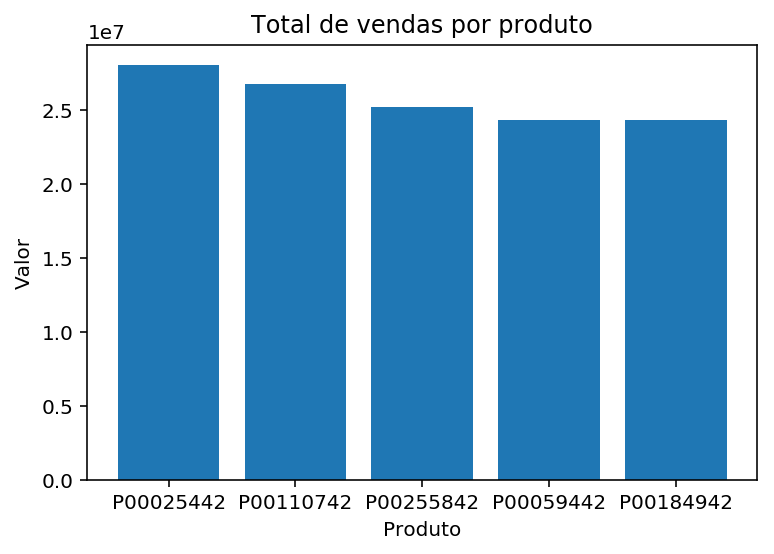

In [39]:
product_n_price = df.groupby(["Product_ID"]).Purchase.sum().sort_values(ascending=False)[0:5]
plt.bar(product_n_price.keys(), product_n_price.values, align='center')
plt.xlabel("Produto")
plt.ylabel("Valor")
plt.title("Total de vendas por produto")
plt.show()

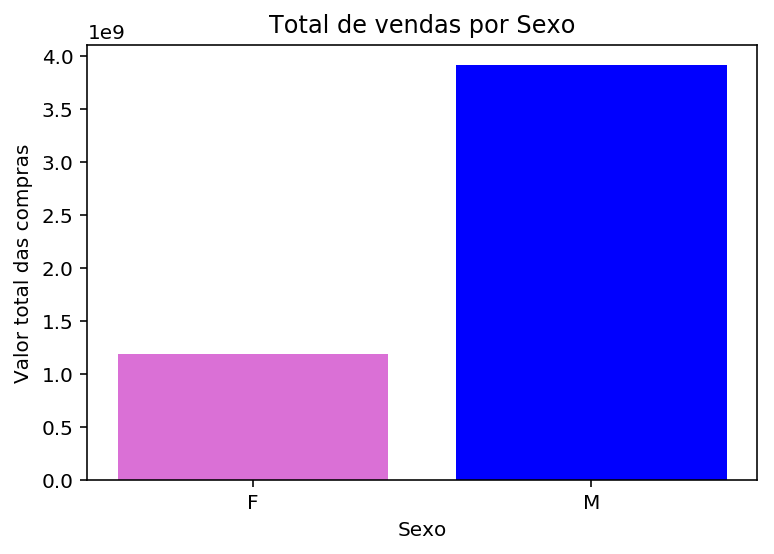

In [40]:
compra_por_genero = df.groupby(['Gender']).Purchase.sum()
plt.bar(compra_por_genero.keys(), compra_por_genero.values, align='center', color = ['orchid', 'Blue'])
plt.xlabel("Sexo")
plt.ylabel("Valor total das compras")
plt.title("Total de vendas por Sexo")
plt.show()

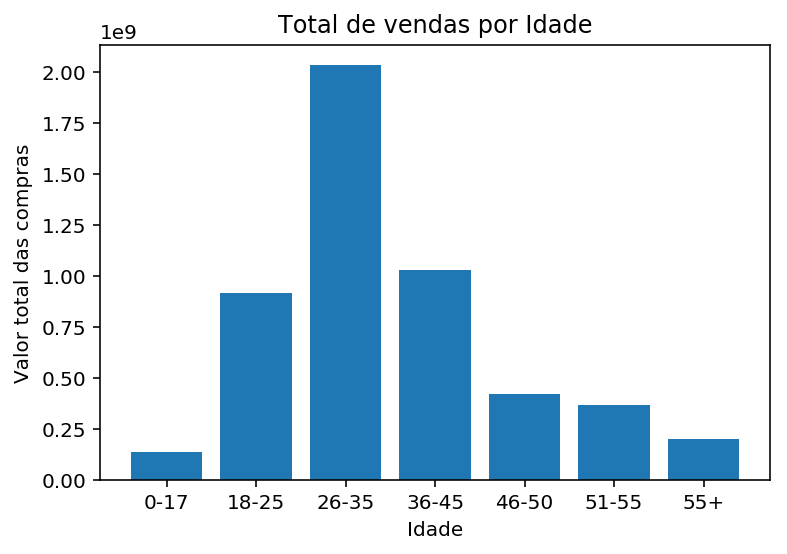

In [41]:
compra_por_genero = df.groupby(['Age']).Purchase.sum()
plt.bar(compra_por_genero.keys(), compra_por_genero.values, align='center')
plt.xlabel("Idade")
plt.ylabel("Valor total das compras")
plt.title("Total de vendas por Idade")
plt.show()

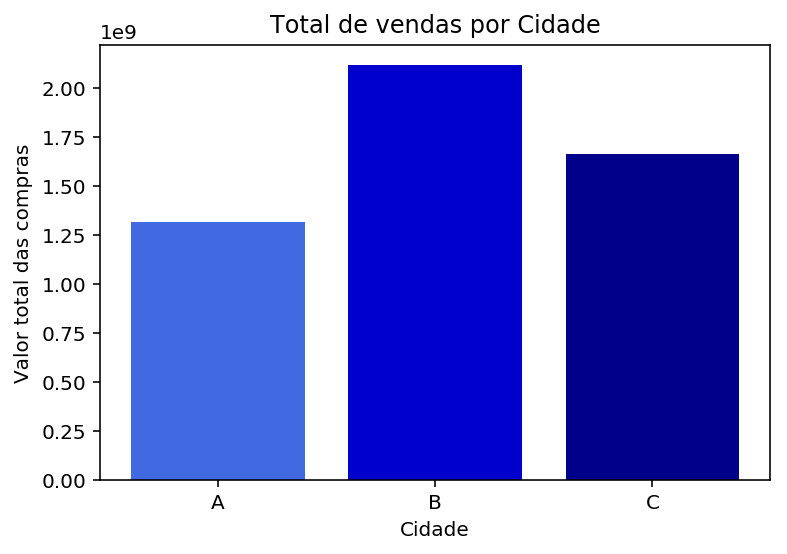

In [42]:
compra_por_genero = df.groupby(['City_Category']).Purchase.sum()
cor = ['royalBlue', 'mediumBlue', 'darkBlue']
plt.bar(compra_por_genero.keys(), compra_por_genero.values, align='center', color=cor)
plt.xlabel("Cidade")
plt.ylabel("Valor total das compras")
plt.title("Total de vendas por Cidade")
plt.show()

In [43]:
compra_sex_EstCivil = df.groupby(['Gender', 'Marital_Status']).Purchase.sum()
compra_sex_EstCivil
# vemos que pessoas solteiras compram mais produtos

Gender  Marital_Status
F       0                  684154127
        1                  502078515
M       0                 2324773320
        1                 1584806780
Name: Purchase, dtype: int64

In [44]:
df.groupby(['Gender', 'Age']).Purchase.sum()

Gender  Age  
F       0-17       42385978
        18-25     205475842
        26-35     442976233
        36-45     243438963
        46-50     116706864
        51-55      89465997
        55+        45782765
M       0-17       92527205
        18-25     708372833
        26-35    1588794345
        36-45     783130921
        46-50     304136539
        51-55     277633647
        55+       154984610
Name: Purchase, dtype: int64

In [45]:
df[df['Gender'] == 0]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,IsCat2,IsCat3


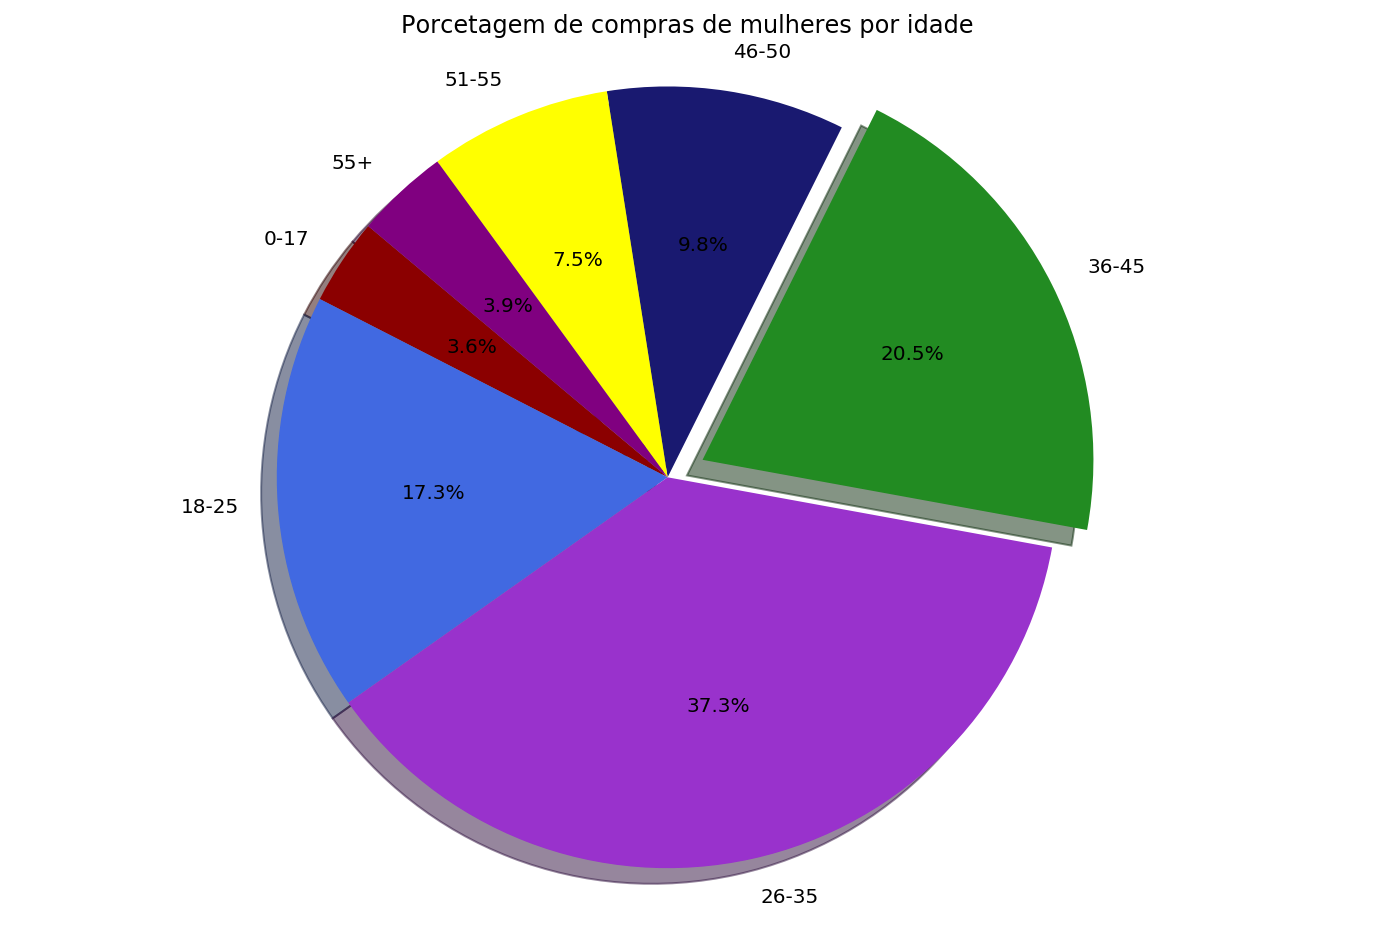

In [46]:
plt.figure(figsize = (12,8))
df_temp = df[df['Gender'] == 'F']
temp_fmale = df_temp.groupby(['Age']).Purchase.sum()
colors = ['darkred', 'royalblue', 'darkorchid', 'forestgreen', 'midnightblue', 'yellow', 'purple']
explode = (0, 0, 0, 0.1, 0, 0, 0)

labels = temp_fmale.keys()
values = temp_fmale.values

plt.pie(values, labels=labels,colors=colors,explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Porcetagem de compras de mulheres por idade")
plt.axis('equal')
plt.show()

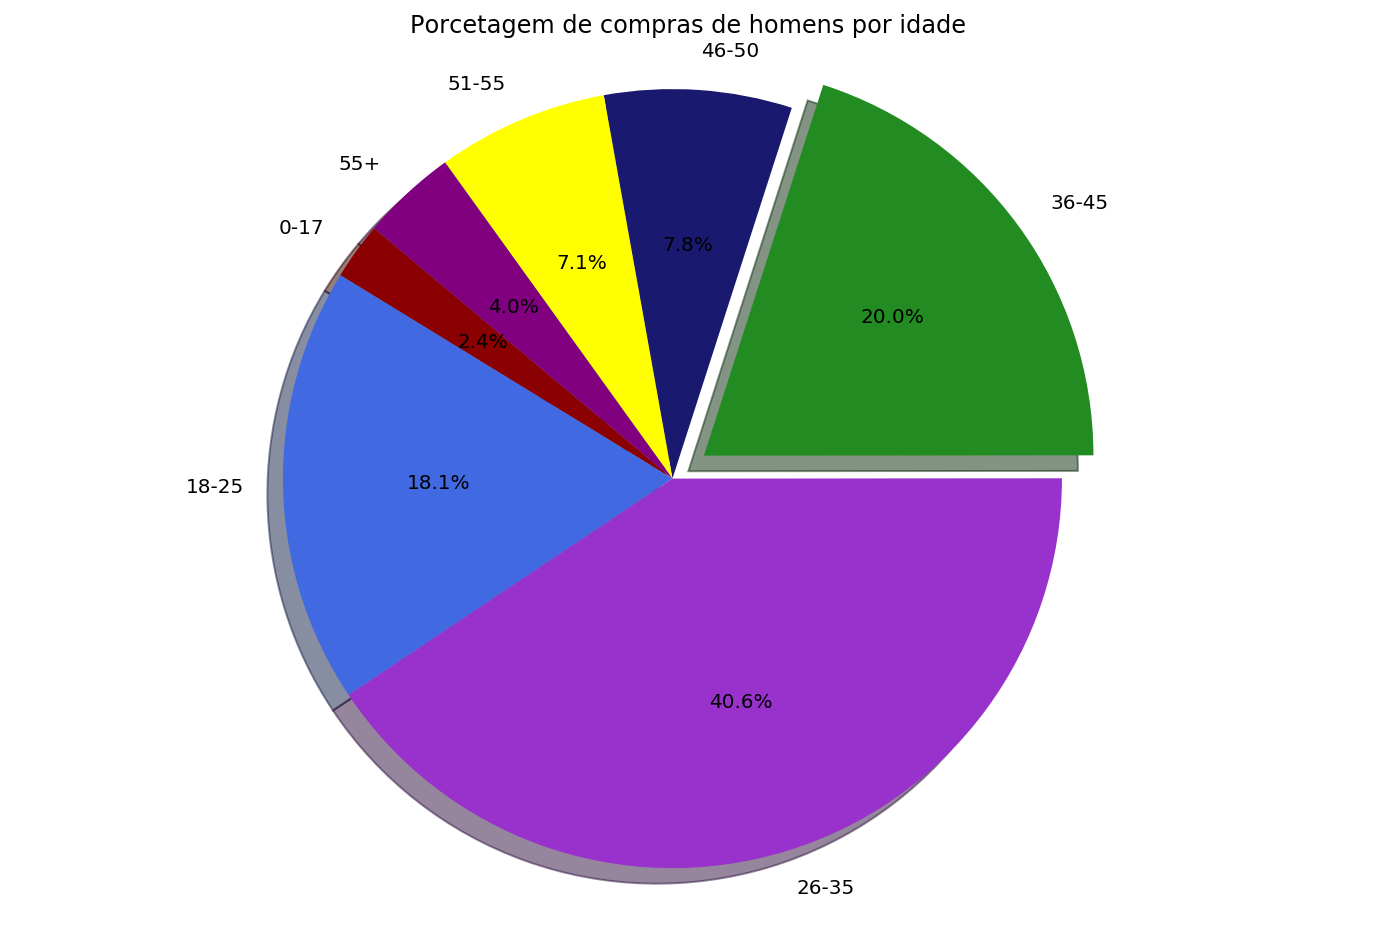

In [47]:
plt.figure(figsize = (12,8))
df_temp = df[df['Gender'] == 'M']
temp_male = df_temp.groupby(['Age']).Purchase.sum()
colors = ['darkred', 'royalblue', 'darkorchid', 'forestgreen', 'midnightblue', 'yellow', 'purple']
explode = (0, 0, 0, 0.1, 0, 0, 0)

labels = temp_male.keys()
values = temp_male.values

plt.pie(values, labels=labels,colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Porcetagem de compras de homens por idade")
plt.axis('equal')
plt.show()

In [48]:
# provavelmente, as ocupações em primeiro no rank são as que têm melhor remuneração
df.groupby(['Occupation']).Purchase.sum().sort_values(ascending=False)

Occupation
4     666244484
0     635406958
7     557371587
1     424614144
17    393281453
12    305449446
20    296570442
14    259454692
16    238346955
2     238028583
6     188416784
3     162002168
15    118960211
10    115844465
5     113649759
11    106751618
19     73700617
13     71919481
18     60721461
9      54340046
8      14737388
Name: Purchase, dtype: int64

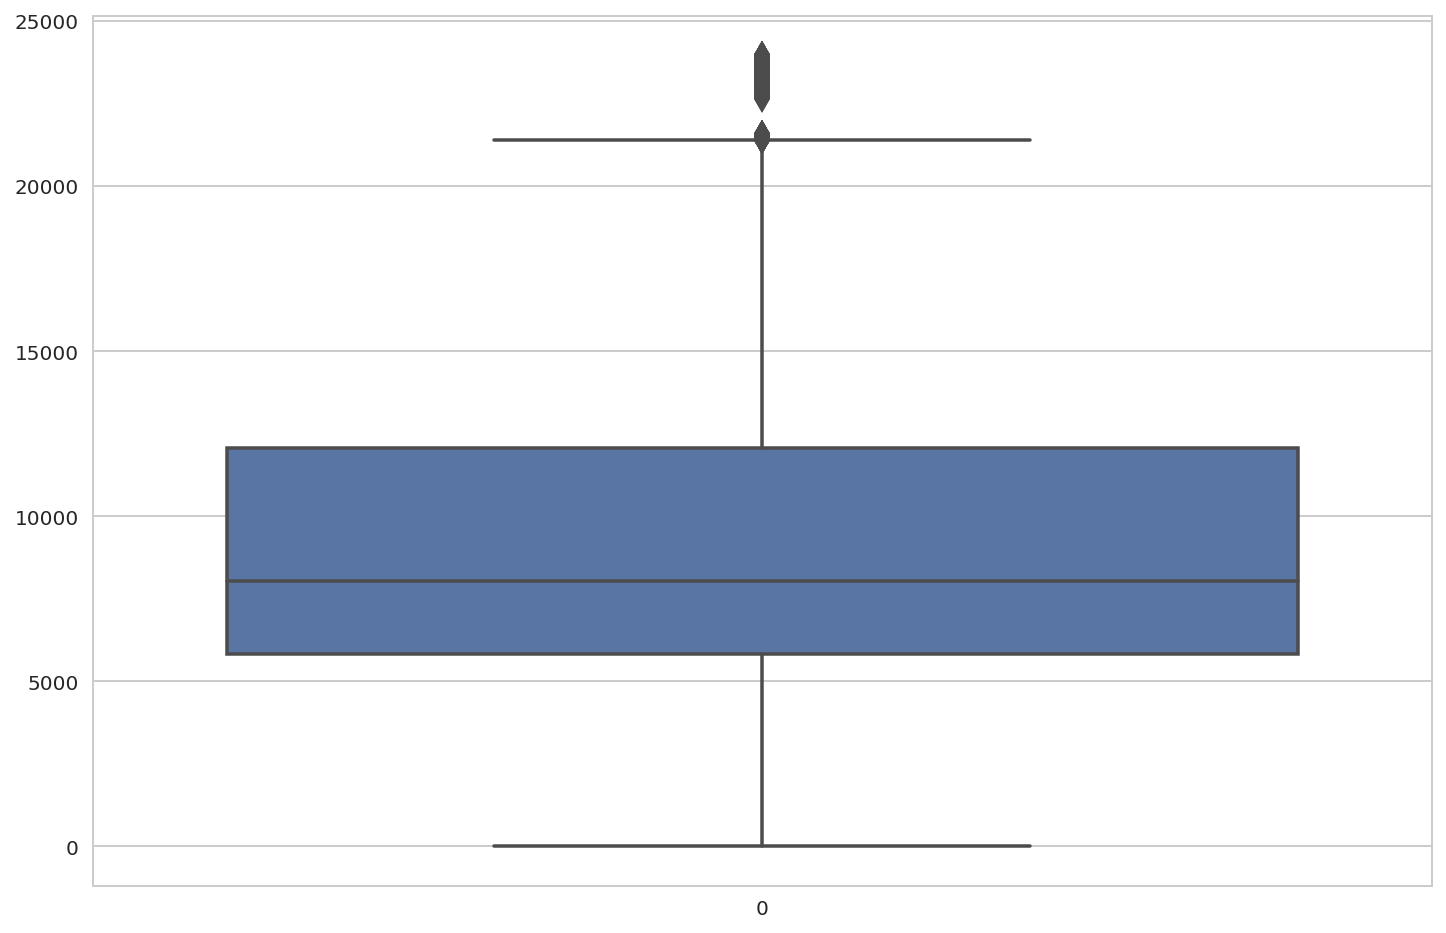

In [49]:
# verificando outliers. Não retirarei os outliers por enquanto
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12,8))
sns.boxplot(data=df['Purchase'], fliersize=10)

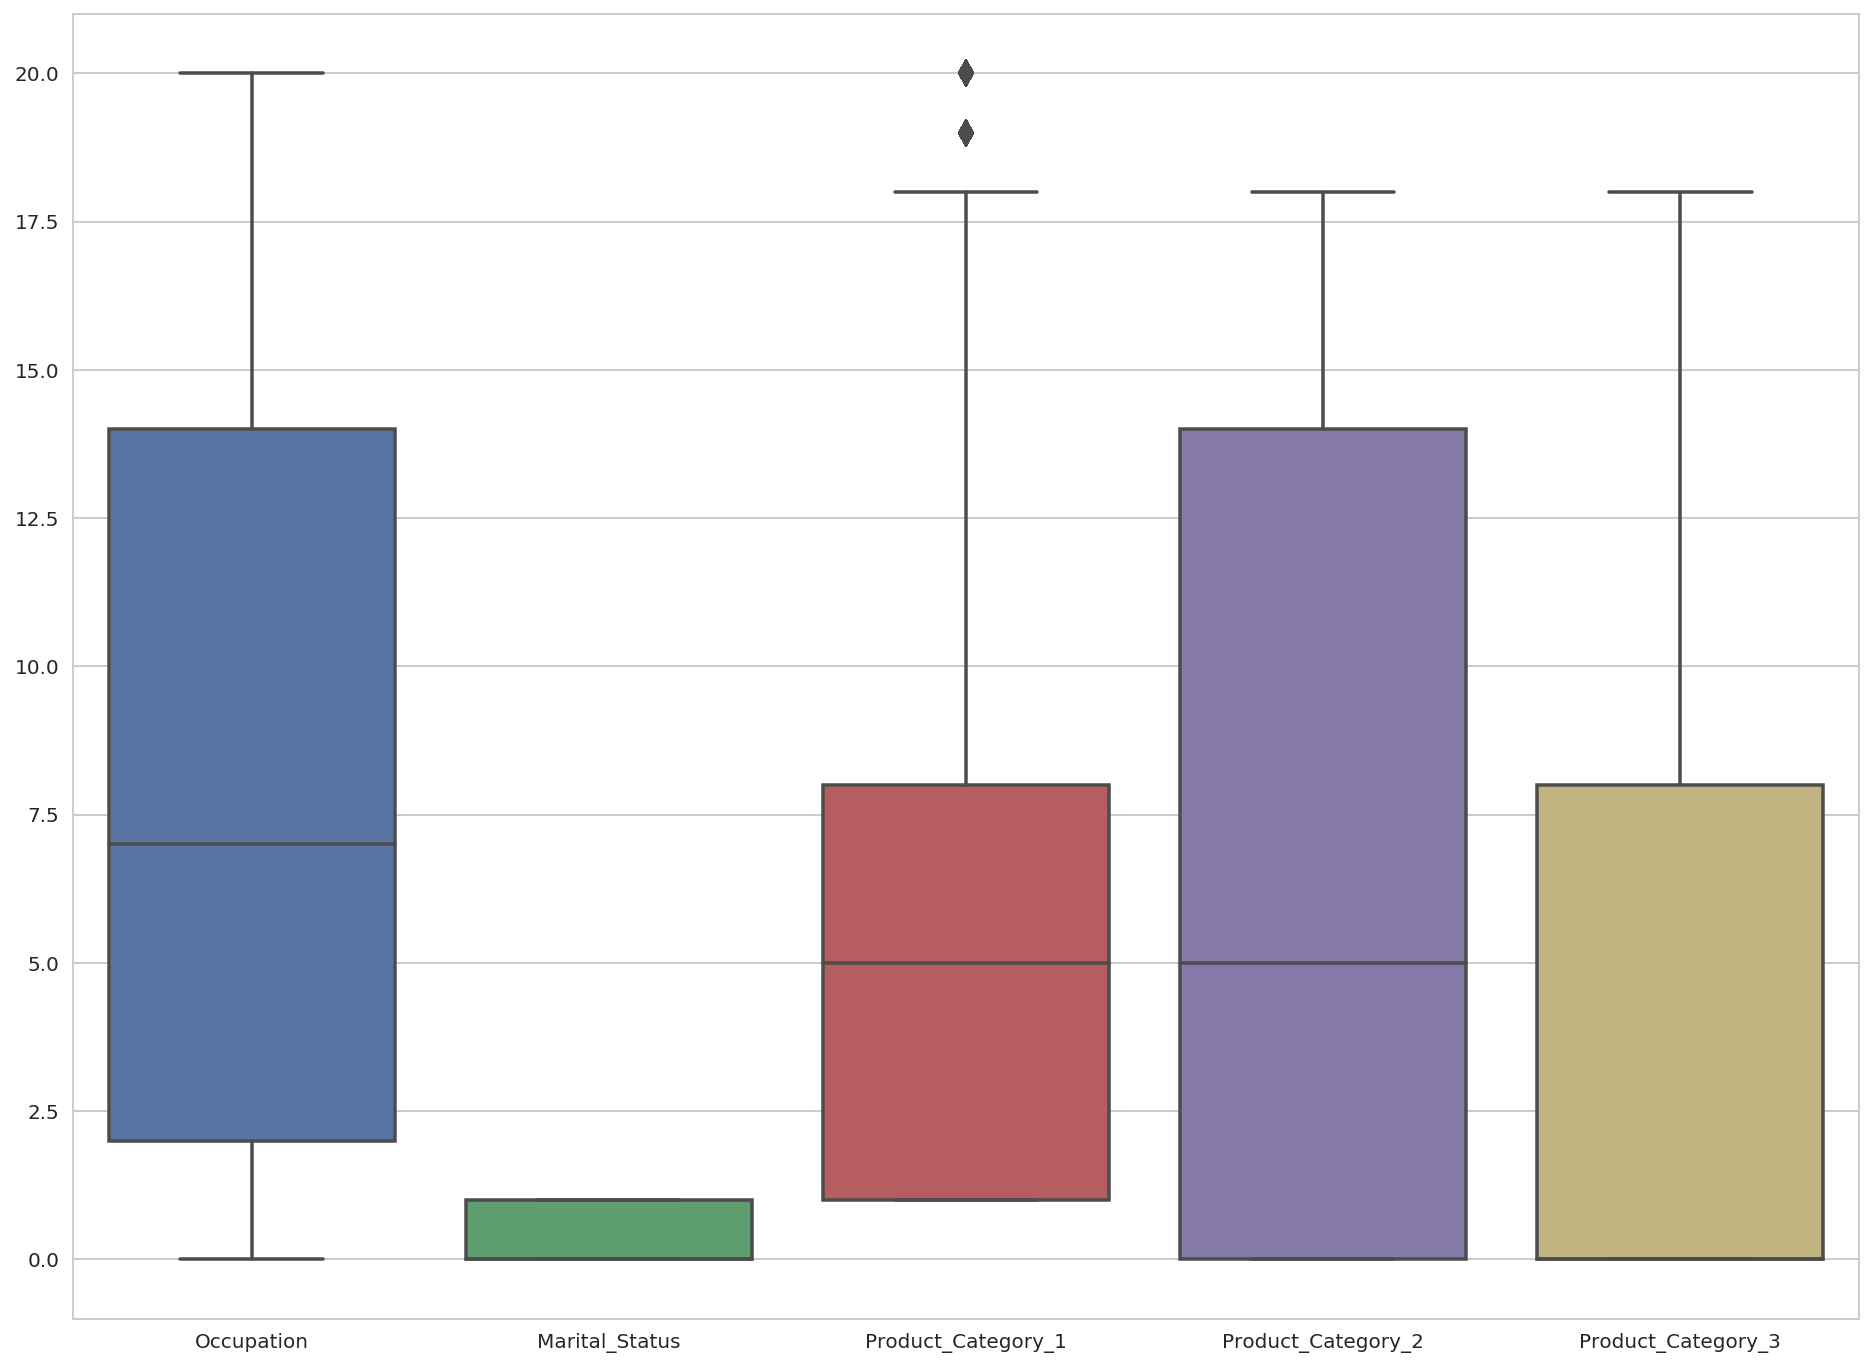

In [50]:
# verificando outliers
col_numeric = ['Occupation', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(16,12))
sns.boxplot(data=df[col_numeric], fliersize=10)

# Transformação dos dados

In [51]:
User_id = df.User_ID
Product_id = df.Product_ID
df.drop(['User_ID', 'Product_ID'], axis = 1, inplace = True)

In [52]:
df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,IsCat2,IsCat3
0,F,0-17,10,A,2,0,3,0.0,0.0,8370,1,1
1,F,0-17,10,A,2,0,1,6.0,14.0,15200,0,0
2,F,0-17,10,A,2,0,12,0.0,0.0,1422,1,1
3,F,0-17,10,A,2,0,12,14.0,0.0,1057,0,1
4,M,55+,16,C,4+,0,8,0.0,0.0,7969,1,1
5,M,26-35,15,A,3,0,1,2.0,0.0,15227,0,1
6,M,46-50,7,B,2,1,1,8.0,17.0,19215,0,0
7,M,46-50,7,B,2,1,1,15.0,0.0,15854,0,1
8,M,46-50,7,B,2,1,1,16.0,0.0,15686,0,1
9,M,26-35,20,A,1,1,8,0.0,0.0,7871,1,1


In [53]:
def sex_to_numeric(x):
    if(x == 'F'):
        # female
        return(0)
    else:
        #male
        return(1)

def cityYears_to_numeric(x):
    if(x == '0'):
        return(0)
    elif(x == '1'):
        return(1)
    elif(x == '2'):
        return(2)
    elif(x == '3'):
        return(3)
    else:
        # 4+
        return(4)

def cityCat_to_numeric(x):
    if(x == "A"):
        return(1)
    elif(x == "B"):
        return(2)
    else:
        # C
        return(3)

def age_to_numeric(x):
    if(x == '0-17'):
        return(1)
    elif(x == '18-25'):
        return(2)
    elif(x == '26-35'):
        return(3)
    elif(x == '36-45'):
        return(4)
    elif(x == '46-50'):
        return(5)
    elif(x == '51-55'):
        return(6)
    else:
        # 55+
        return(7)
    
def occu_to_numeric(x):
    return(int(x))

In [54]:
# aplicando as funções
df.Gender = df.Gender.apply(sex_to_numeric)
df.Age = df.Age.apply(age_to_numeric)
df.City_Category = df.City_Category.apply(cityCat_to_numeric)
df.Occupation = df.Occupation.apply(occu_to_numeric)
df.Stay_In_Current_City_Years = df.Stay_In_Current_City_Years.apply(cityYears_to_numeric)

# Criando os modelos de ML

In [55]:
corr = df.corr()
corr

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,IsCat2,IsCat3
Gender,1.000000,-0.004262,0.117291,-0.004515,0.014660,-0.011603,-0.045594,-0.000954,0.036146,0.060346,-0.012778,-0.032956
Age,-0.004262,1.000000,0.091463,0.123079,-0.004712,0.311738,0.061197,0.018770,-0.007422,0.015839,0.016060,0.020118
Occupation,0.117291,0.091463,1.000000,0.034479,0.030005,0.024280,-0.007618,0.006712,0.012269,0.020833,-0.009411,-0.010335
City_Category,-0.004515,0.123079,0.034479,1.000000,0.019946,0.039790,-0.014364,0.016003,0.035525,0.061914,-0.030737,-0.038637
Stay_In_Current_City_Years,0.014660,-0.004712,0.030005,0.019946,1.000000,-0.012819,-0.004213,0.001262,0.001977,0.005422,-0.002972,-0.001674
Marital_Status,-0.011603,0.311738,0.024280,0.039790,-0.012819,1.000000,0.019888,0.001099,-0.004629,-0.000463,0.010011,0.009142
Product_Category_1,-0.045594,0.061197,-0.007618,-0.014364,-0.004213,0.019888,1.000000,-0.067877,-0.385534,-0.343703,0.435959,0.446103
Product_Category_2,-0.000954,0.018770,0.006712,0.016003,0.001262,0.001099,-0.067877,1.000000,0.094750,0.052288,-0.735988,-0.017136
Product_Category_3,0.036146,-0.007422,0.012269,0.035525,0.001977,-0.004629,-0.385534,0.094750,1.000000,0.288501,-0.417448,-0.931613
Purchase,0.060346,0.015839,0.020833,0.061914,0.005422,-0.000463,-0.343703,0.052288,0.288501,1.000000,-0.235980,-0.314462


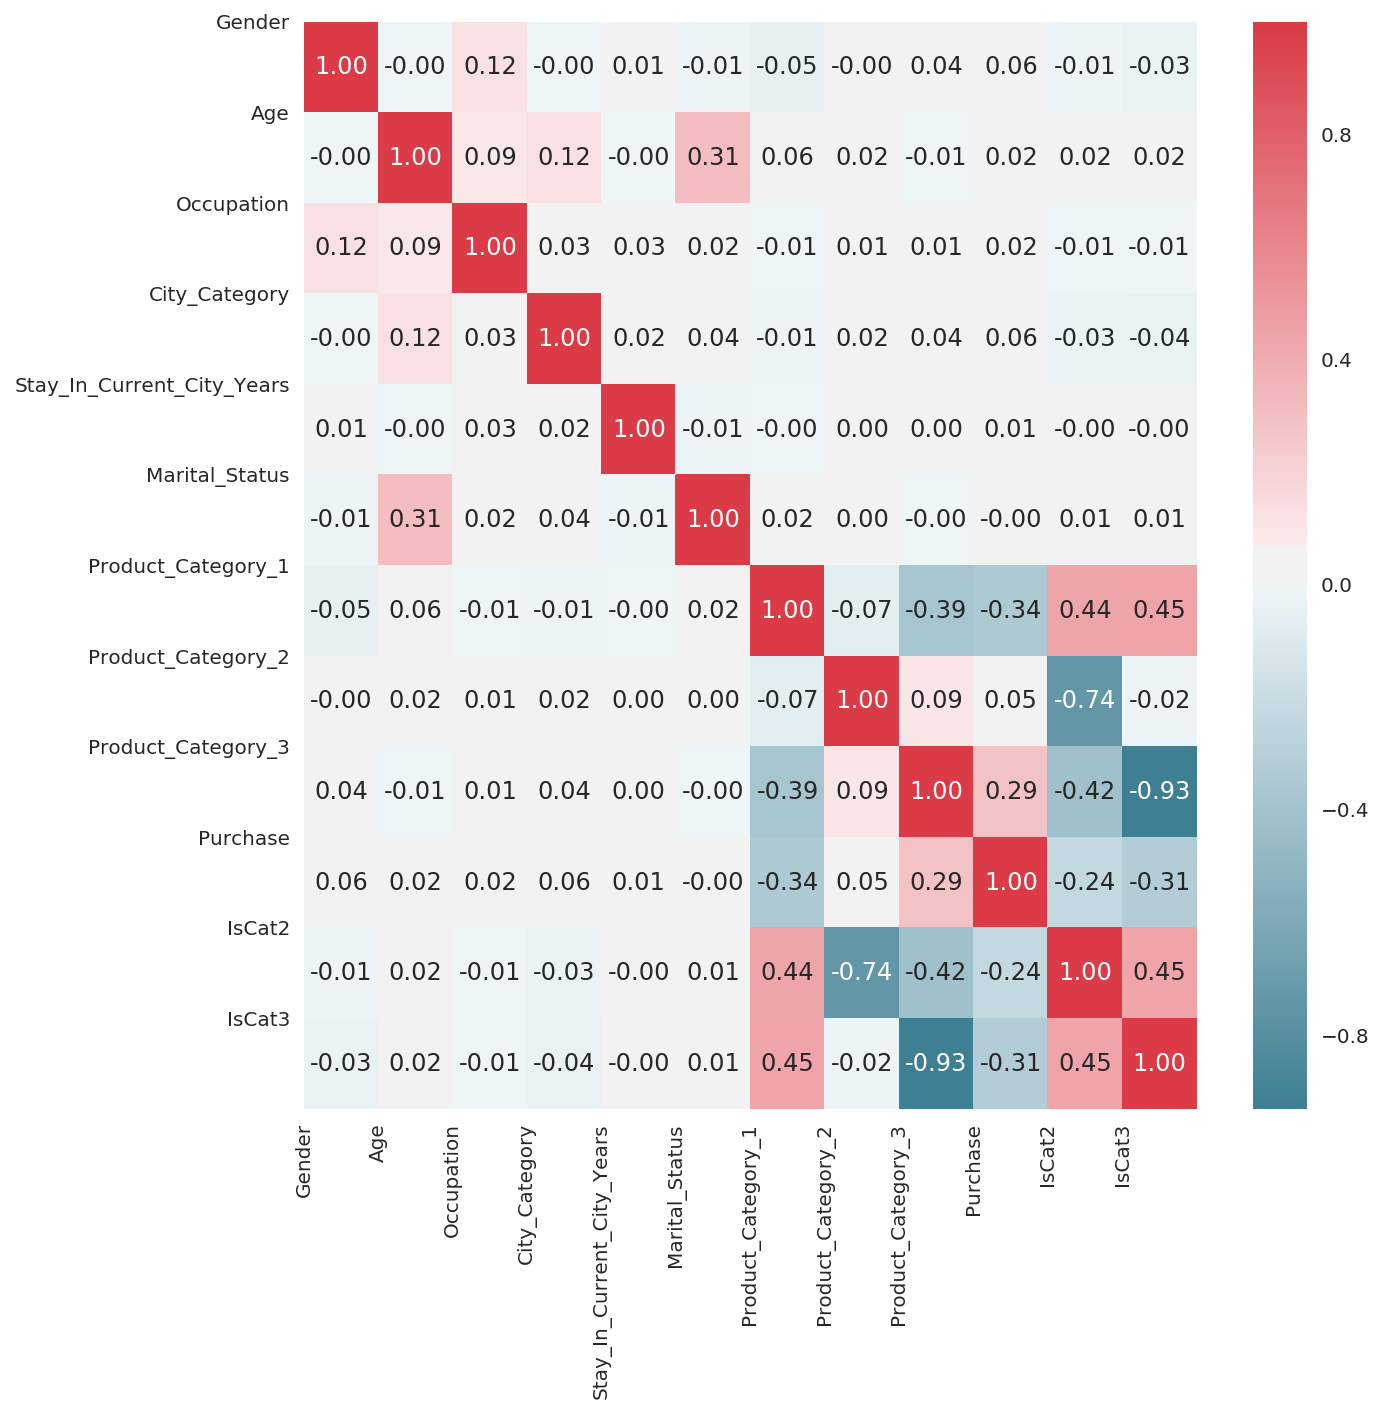

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))

colormap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")

plt.xticks(range(len(corr.columns)), corr.columns);

plt.yticks(range(len(corr.columns)), corr.columns)

plt.show()

In [57]:
df['Product_cat1'] = (df.Product_Category_1)**2

In [58]:
# aplicando a normalização.
colunas = df.columns
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
df = pd.DataFrame(scaled_df, columns=colunas)

In [59]:
train, test = train_test_split(df, test_size = 0.2)

In [60]:
train_target = train.Purchase
train.drop(['Purchase'], axis = 1, inplace=True)

In [61]:
test_target = test.Purchase
test.drop(['Purchase'], axis = 1, inplace=True)

In [62]:
xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.5, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=4) 

In [63]:
tree_model = RandomForestRegressor(n_estimators=100, random_state=0)

In [64]:
tree_model.fit(train, train_target)
pred = tree_model.predict(test)
explained_variance_score(test_target, pred)

0.6308242649903071

In [65]:
xgb_model.fit(train, train_target)
pred = xgb_model.predict(test)
explained_variance_score(test_target, pred)

[16:43:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6632964155438135

In [66]:
print(xgb_model.feature_importances_)

[0.00528484 0.00674437 0.00577601 0.01642372 0.00528484 0.00503035
 0.9056465  0.02197236 0.02783696 0.         0.         0.        ]


In [67]:
print(tree_model.feature_importances_)

[0.01352974 0.03718607 0.06299119 0.01549088 0.04326568 0.0169326
 0.35143875 0.02574822 0.01639196 0.00124916 0.00139743 0.41437832]
